# Visualize

## 1. Imports

In [1]:
import os
import re
import gc
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from copy import deepcopy
import plotly.express as px
from plotly.offline import plot
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# import plotly.io as pio
# pio.renderers.default = "notebook"


warnings.filterwarnings("ignore")
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
if sns.__version__ != '0.12.1': raise NotImplementedError

### Supporting Functions

In [2]:
base_dir = './visuals'

subset=''
history={}
history_dict={}

# Access dictionary with dot notation
class dotdict(dict):    
    """dot.notation access to dictionary attributes"""      
    def __getattr__(*args):        
        val = dict.get(*args)         
        return dotdict(val) if type(val) is dict else val     
    __setattr__ = dict.__setitem__     
    __delattr__ = dict.__delitem__

# Alphanumeric sorting
def alpha_sort(iterable): 
    """ Sort the given iterable in the way that humans expect.""" 
    if iterable[0] and not isinstance(iterable[0], str): return sorted(iterable)
    else:
        convert = lambda text: int(text) if text.isdigit() else text 
        alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
        return sorted(iterable, key = alphanum_key)

# Make save directory
def make_save_dir(base_dir,history):
    dataset = ""
    for data in history_dict.datasets:
        if data in history['config']['train_data_path']:
            dataset = data
            break
    assert dataset != '', "Unknown dataset."

    strategy = history['strategy'] if history['config']['equal_split'] else 'random_'+history['strategy']
    plots_dir = os.path.join(base_dir,dataset,strategy)
    strat_value = str(history['config'][history['strategy']])

    config_str = strat_value+'_LC_'+str(len(history['config']['labeled_classes']))  +'_UC_'+str(len(history['config']['unlabeled_classes']))+\
                '_LS_'+str(history['labeled_set_size'][0])+'_US_'+str(history['unlabeled_set_size'][0])
    plots_dir = os.path.join(plots_dir,config_str)
    os.makedirs(plots_dir,exist_ok=True)

    return plots_dir#, config_str

# Class labels
class_labels = {'dbpedia_14':{0:'Company', 1:'Edu Institution', 2:'Artist', 3:'Athlete', 4:'Office Holder',5:'Mean Of Trans', 6:'Building',\
                              7:'Natural Place', 8:'Village', 9:'Animal', 10:'Plant', 11:'Album', 12:'Film', 13:'Written Work'},
                'yahoo_answers_10':{0:"Society", 1:"Science", 2:"Health", 3:"Education", 4:"Computers",\
                                    5:"Sports", 6:"Business", 7:"Music", 8:"Family", 9:"Politics"}}

## 2. Load History Files

### Consolidate

In [ ]:
history_dir = './history'
history_dict = dict()
for path, dirs, files in os.walk(history_dir):
    if not dirs:
        dataset = path.split('/')[-2]
        strategy = path.split('/')[-1]
        for file_ in files:
            if dataset in history_dict:
                history_dict[dataset][strategy] = []
            else:
                history_dict[dataset] = {strategy:[]}
                
            for file_ in alpha_sort(files):
                history_dict[dataset][strategy].append(torch.load(os.path.join(path,file_)))

### Save

In [ ]:
save_path = './history/consolidated_history.pt'
torch.save(history_dict,save_path)

### Load

In [3]:
save_path = './history/consolidated_history.pt'
history_dict = dotdict(torch.load(save_path))
history_dict.datasets = list(history_dict.keys())
history_dict.strategies = [list(history_dict[dataset].keys()) for dataset in history_dict.datasets]

### Info

In [ ]:
print('Datasets  :',history_dict.datasets)
print('Strategies:',history_dict.strategies)
print('\nHistory keys:', history_dict[history_dict.datasets[0]][history_dict.strategies[0][0]][0].keys())
print('\nConfig keys :', history_dict[history_dict.datasets[0]][history_dict.strategies[0][0]][0]['config'].keys())

print('\nFile Counts:')
for dataset in history_dict.datasets:
    print('\nDataset:', dataset)
    for strategy, val in history_dict[dataset].items():
        print(len(val), strategy)

Datasets  : ['dbpedia_14', 'yahoo_answers_10']
Strategies: [['pc_top_k', 'random_top_k', 'random_pc_top_k', 'top_k', 'threshold'], ['pc_top_k', 'random_top_k', 'random_pc_top_k', 'top_k']]

History keys: dict_keys(['strategy', 'config', 'iteration', 'batch_size', 'epoch', 'train_loss', 'train_acc', 'val_loss', 'val_cw_f1', 'val_acc', 'val_cw_acc', 'labeled_set_size', 'unlabeled_set_size', 'selected_set_size', 'selected_in_domain', 'selected_out_domain', 'train_distribution', 'labeled_distribution', 'unlabeled_distribution', 'selected_distribution', 'predicted_distribution', 'pseudo_distribution', 'predicted_probs', 'predicted_prob_mean', 'predicted_prob_std', 'predicted_prob_max', 'predicted_prob_min', 'selected_probs', 'selected_prob_mean', 'selected_prob_std', 'selected_prob_max', 'selected_prob_min'])

Config keys : dict_keys(['strategy', 'cache_dir', 'labeled_classes', 'unlabeled_classes', 'eval_size', 'labeled_size', 'unlabeled_size', 'labeled_per_class', 'unlabeled_per_class', 't

## 3. Plots

### 3.1 Probability Distribution Plots

#### Supporting Methods

In [6]:
# Function to label the plot in axes coordinates
def prob_label(x, color, label):
    ax = plt.gca()
    
    ax.text(0.05, .3, str(int(label)+1), fontsize='small',#color=color,# fontweight="bold",
        ha="left", va="center", transform=ax.transAxes)
    min_ = '%.2f  '  %(history[subset+'_prob_min'][int(label)])
    max_ = '%.2f    '%(history[subset+'_prob_max'][int(label)])
    std  = '%.2f   ' %(history[subset+'_prob_std'][int(label)])
    mean = '%.2f'    %(history[subset+'_prob_mean'][int(label)])
    stat = min_+max_+std+mean
    ax.text(1, .3, stat, fontsize='small',#color=color,# fontweight="bold",
        ha="left", va="center", transform=ax.transAxes)

# Function to label the plot in axes coordinates
def sel_prob_label(x, color, label):
    ax = plt.gca()
    
    ax.text(0.05, .3, str(int(label)+1), fontsize='small',#color=color,# fontweight="bold",
        ha="left", va="center", transform=ax.transAxes)
    min_ = '%.2f  '  %(history['selected_prob_min'][int(label)])
    max_ = '%.2f    '%(history['selected_prob_max'][int(label)])
    std  = '%.2f   ' %(history['selected_prob_std'][int(label)])
    mean = '%.2f'    %(history['selected_prob_mean'][int(label)])
    stat = min_+max_+std+mean
    ax.text(1, .3, stat, fontsize='small',#color=color,# fontweight="bold",
        ha="left", va="center", transform=ax.transAxes)

#### Plot

In [ ]:
dataset = history_dict.datasets[1]
strategy = history_dict.strategies[1][1]
history_list = history_dict[dataset][strategy]

iter_lens = [len(history['iteration']) for history in history_list]
sorted_ = sorted(list(set(iter_lens)))
indices = [iter_lens.index(val) for val in sorted_]
print('Dataset  :', dataset)
print('Strategy :', strategy)
print('Indices  :', indices)
print('Unique   :', sorted_)
print('Iter Lens:', iter_lens)

Dataset  : yahoo_answers_10
Strategy : random_top_k
Indices  : [20, 0, 1, 3]
Unique   : [11, 21, 41, 81]
Iter Lens: [21, 41, 41, 81, 21, 41, 41, 81, 21, 41, 41, 81, 21, 41, 41, 81, 21, 41, 41, 81, 11, 21, 21, 41, 11, 21, 21, 41, 11, 21, 21, 41, 11, 21, 21, 41, 11, 21, 21, 41]


In [ ]:
indices =  [20, 0, 1]
subset = 'predicted' # selected , predicted

for index in indices:
    # Load Probs from history
    history = history_list[index]

    # Make a dataframe to plot
    probs = []
    iterations = []
    for itr, prob_list in enumerate(history[subset+'_probs']):
        probs += list(prob_list)
        iterations += ([itr]*len(prob_list))
    df = pd.DataFrame(dict(probability=probs, iteration=iterations))

    # Set size to ensure same width
    iterations = len(history['iteration'])
    height = 0.5
    # width = (0.001 * iterations) + 6 if iterations > 15 else (0.001 * iterations) + 4.4
    aspect = 12 if iterations > 22 else 8.2

    # Initialize the FacetGrid object
    grid = sns.FacetGrid(df, row="iteration", hue="iteration", aspect=aspect, height=height,
        sharey=False, sharex=True, palette=sns.color_palette("husl", len(history['iteration'])))

    # Plot the densities
    line_color = {'selected':'black', 'predicted':'white'}
    line_width = {'selected':1, 'predicted':1.5}
    grid.map(sns.kdeplot, "probability", fill=False, alpha = 1,color = line_color[subset], lw=line_width[subset], clip_on=False)
    grid.map(sns.kdeplot, "probability", fill=True, alpha = 1, lw = 1.2,clip_on=False)

    # Passing color=None to refline() uses the hue mapping
    grid.refline(y=-0, linewidth=0.3, linestyle="-", color=None, clip_on=False)

    # Set labels
    grid.map(prob_label, "probability")

    # Set the subplots to overlap
    grid.figure.subplots_adjust(hspace=-.15)

    # Set axes details
    grid.set_titles("")
    grid.set(yticks=[], ylabel="")
    grid.despine(bottom=True, left=True)
    plt.xticks([0.2,0.4,0.6,0.8,1.0], fontsize='small')

    # Set headings
    plt.suptitle(subset.title()+" Probability Distribution",fontsize='large', y = 1.005)
    plt.text(0,.8,"Iteration",transform=plt.gcf().get_axes()[0].transAxes, fontdict={'fontsize':'medium'})
    plt.text(1,.8,"Min  Max  STD  Mean",transform=plt.gcf().get_axes()[0].transAxes,fontdict={'fontsize':'medium'})

    # Plot
    # plt.savefig(str(len(history['iteration'])),bbox_inches='tight')
    plt.show();
    ####################################################

#### Save

In [ ]:
datasets = history_dict.datasets
strategies = history_dict.strategies[1]
subsets = ['selected' , 'predicted']
for dataset in datasets:
    for strategy in strategies:
        history_list = history_dict[dataset][strategy]
        for subset in subsets:
            for history in tqdm(history_list, desc=dataset.title()+', '+strategy.title()+', '+subset.title()):
                # Make save dir
                plots_dir = make_save_dir(base_dir,history)
                
                # Make a dataframe to plot
                probs = []
                iterations = []
                for itr, prob_list in enumerate(history[subset+'_probs']):
                    probs += list(prob_list)
                    iterations += ([itr]*len(prob_list))
                df = pd.DataFrame(dict(probability=probs, iteration=iterations))

                # Set size to ensure same width
                iterations = len(history['iteration'])
                height = 0.5
                aspect = 12 if iterations > 22 else 8.2

                # Initialize the FacetGrid object
                grid = sns.FacetGrid(df, row="iteration", hue="iteration", aspect=aspect, height=height,
                    sharey=False, sharex=True, palette=sns.color_palette("husl", len(history['iteration'])))

                # Plot the densities
                line_color = {'selected':'black', 'predicted':'white'}
                line_width = {'selected':1, 'predicted':1.5}
                # grid.map(sns.kdeplot, "probability", fill=False, alpha = 1,color = line_color[subset], lw=line_width[subset], clip_on=False)
                grid.map(sns.kdeplot, "probability", fill=False, alpha = 1,color = 'black', lw=1, clip_on=False)
                grid.map(sns.kdeplot, "probability", fill=True, alpha = 1, lw = 1.2, clip_on=False)

                # Passing color=None to refline() uses the hue mapping
                grid.refline(y=-0, linewidth=0.3, linestyle="-", color=None, clip_on=False)

                # Set labels
                grid.map(prob_label, "probability")

                # Set the subplots to overlap
                grid.figure.subplots_adjust(hspace=-.15)

                # Set axes details
                grid.set_titles("")
                grid.set(yticks=[], ylabel="")
                grid.despine(bottom=True, left=True)
                plt.xticks([0.2,0.4,0.6,0.8,1.0], fontsize='small')

                # Set headings
                plt.suptitle(subset.title()+" Probability Distribution",fontsize='large',x=0.55, y = 1.005)
                plt.text(0,.8,"Iteration",transform=plt.gcf().get_axes()[0].transAxes, fontdict={'fontsize':'medium'})
                plt.text(1,.8,"Min  Max  STD  Mean",transform=plt.gcf().get_axes()[0].transAxes,fontdict={'fontsize':'medium'})

                # Save
                # plt.savefig(plots_dir+'/'+config_str+' '+subset+"_prob_dist.png",bbox_inches="tight");
                # plt.savefig(plots_dir+'/'+subset+"_prob_dist.png",bbox_inches="tight");
                plt.clf();
                plt.close('all');
                del(df)
                del(history)
                del(grid)
                gc.collect()

### 3.2 Class Distribution Plots

#### Supporting Methods

In [10]:
# Function to label the plot in axes coordinates
def class_label(x, color, label):
    ax = plt.gca()
    if subset.lower() == 'selected':
        txt = history['selected_set_size'][int(label)]
        in_do = ' '*(3-len(str(txt)))+'   '+str(history['selected_in_domain'][int(label)]) +' '*(3-len(str(history['selected_in_domain'][int(label)])))
        out_do = '   '+str(history['selected_out_domain'][int(label)])
        txt = str(txt) + in_do + out_do
    elif subset.lower() == 'labeled' or subset.lower() == 'train':
        txt = history['labeled_set_size'][int(label)]
    elif subset.lower() == 'unlabeled' or subset.lower() == 'predicted':
        txt = history['unlabeled_set_size'][int(label)]
    elif subset.lower() == 'pseudo':
        txt = history['selected_set_size'][int(label)]
    else: raise NotImplementedError
    
    ax.text(-0.15, .2, str(int(label)+1), fontsize='small', ha="left", va="center", transform=ax.transAxes)
    ax.text(1.05, .2, str(txt), fontsize='small', ha="left", va="center", transform=ax.transAxes)

#### Plot

In [15]:
dataset = history_dict.datasets[1]
strategy = history_dict.strategies[1][0]
history_list = history_dict[dataset][strategy]

subset = 'train'      # 'pseudo', 'labeled', 'unlabeled', 'train', 'predicted', 'selected', 

iter_lens = [str(len(history[subset.lower()+'_distribution']))+' '+str(len(history[subset.lower()+'_distribution'][0])) for history in history_list]
sorted_ = alpha_sort(list(set(iter_lens)))
indices = [iter_lens.index(val) for val in sorted_]
print('Dataset  :', dataset)
print('Strategy :', strategy)
print('Subset   :', subset)
print('Indices  :', indices)
print('\nUnique   :', *zip(sorted_,indices))
print('\nIter Lens:', iter_lens)

Dataset  : yahoo_answers_10
Strategy : pc_top_k
Subset   : train
Indices  : [24, 20, 4, 0, 1, 6, 15, 7, 3]

Unique   : ('12 5', 24) ('13 5', 20) ('22 5', 4) ('23 5', 0) ('42 5', 1) ('43 5', 6) ('82 5', 15) ('83 5', 7) ('85 5', 3)

Iter Lens: ['23 5', '42 5', '42 5', '85 5', '22 5', '42 5', '43 5', '83 5', '22 5', '42 5', '42 5', '83 5', '22 5', '42 5', '42 5', '82 5', '22 5', '43 5', '42 5', '82 5', '13 5', '23 5', '22 5', '42 5', '12 5', '22 5', '22 5', '43 5', '12 5', '22 5', '23 5', '42 5', '12 5', '22 5', '22 5', '42 5', '12 5', '22 5', '22 5', '42 5']


In [ ]:
indices = [28, 0, 6]

for index in indices:
    # Load distribution from history
    history = history_list[index]

    # Make a dataframe to plot
    classes = []
    count = []
    total = []
    iteration = []
    for itr, dist in enumerate(history[subset.lower()+'_distribution']):
        classes += list(dist.keys())
        count += list(dist.values())
        total += list(history['unlabeled_distribution'][itr].values())
        iteration += [itr]*len(list(dist.keys()))

    if subset == 'selected': df = pd.DataFrame(dict(classes=classes, count=count, total=total, iteration=iteration))
    else: df = pd.DataFrame(dict(classes=classes, count=count, iteration=iteration))

    # Initialize the FacetGrid object
    iterations  = len(history[subset.lower() + '_distribution'])
    class_count = len(history[subset.lower() + '_distribution'][0])

    if dataset == 'dbpedia_14':
        if subset == 'selected':
            if class_count == 14: aspect = 12 if iterations > 22 else 9
            else: aspect = 7.8 if iterations > 21 else 4.5
        elif subset == 'pseudo' or subset == 'predicted':
            aspect = 6.5 if iterations > 21 else 4.5
        else:
            if class_count == 14: aspect = 11   
            else: aspect = 6.6 if iterations > 15 else 4.5
    elif dataset == 'yahoo_answers_10':
        if subset == 'selected':
            if class_count == 10: 
                if iterations > 21: aspect = 10
                elif iterations > 15: aspect = 6.7
                else: aspect = 6.3
            else: 
                if iterations > 21: aspect = 6.8 
                elif iterations > 15: aspect = 4
                else: aspect= 3.3
        elif subset == 'pseudo':
            if iterations > 21: aspect = 5.1  
            elif iterations > 15: aspect = 4  
            else: aspect = 3.3
        elif subset == 'predicted':
            if iterations > 21: aspect = 5.7
            elif iterations > 15: aspect = 4  
            else: aspect = 3.3
        else: 
            if iterations > 21: aspect = 5.7
            elif iterations > 15: aspect = 4  
            else: aspect = 3.3
    else: raise NotImplementedError
    
    # Set size to ensure same width
    height = 0.5
    grid = sns.FacetGrid(df, row="iteration", hue="iteration", aspect=aspect, height=height,\
        sharey=True if subset=='selected' else False, sharex=True, palette=sns.color_palette("husl", iterations))

    # Draw the densities in a few steps
    if subset=='selected':
        grid.map(sns.barplot, 'classes', 'total', errorbar=None, alpha=0.4, clip_on=False)    
    grid.map(sns.barplot, 'classes', 'count', errorbar=None, clip_on=False)
        
    # Passing color=None to refline() uses the hue mapping
    grid.refline(y=0, linewidth=0.5, linestyle="-", color=None, clip_on=False)

    # Set labels
    grid.map(class_label, "classes")

    # Set the subplots to overlap
    grid.figure.subplots_adjust(hspace=-.005)

    # Set axes details
    grid.set_titles("")
    grid.set(yticks=[], ylabel="")
    grid.despine(bottom=True, left=True)

    # Set headings
    ticks = list(history[subset.lower()+'_distribution'][0].keys())
    labels = [class_labels[dataset][tick] for tick in ticks]
    plt.xticks(ticks,labels=labels,rotation='vertical')
    plt.suptitle(subset.title()+" Set Class Distribution", fontsize='large', x=0.5, y=1.005)
    plt.text(-0.15,1,"Iteration", transform=plt.gcf().get_axes()[0].transAxes, fontdict={'fontsize':'medium'})
    if subset =='selected':
        plt.text(1.05,1,'Size  In  Out', transform=plt.gcf().get_axes()[0].transAxes, fontdict={'fontsize':'medium'})
    else:
        plt.text(1.05,1,'Size', transform=plt.gcf().get_axes()[0].transAxes, fontdict={'fontsize':'medium'})

    # Plot
    # plt.savefig('ztest/'+str(iterations)+'_'+subset,bbox_inches="tight")
    plt.show();
    ##

#### Save

In [18]:
# ['pseudo', 'labeled', 'unlabeled', 'train', 'predicted', 'selected']
datasets = history_dict.datasets
strategies = history_dict.strategies[1]
subsets = ['train']#,'pseudo','predicted','selected']
for dataset in datasets:
    for strategy in strategies:
        history_list = history_dict[dataset][strategy]
        for subset in subsets:
            for history in tqdm(history_list, desc=dataset.title()+', '+strategy.title()+', '+subset.title()):

                # Make save dir
                plots_dir = make_save_dir(base_dir,history)

                # Make a dataframe to plot
                classes = []
                count = []
                total = []
                iteration = []
                for itr, dist in enumerate(history[subset.lower()+'_distribution']):
                    classes += list(dist.keys())
                    count += list(dist.values())
                    total += list(history['unlabeled_distribution'][itr].values())
                    iteration += [itr]*len(list(dist.keys()))

                if subset == 'selected': df = pd.DataFrame(dict(classes=classes, count=count, total=total, iteration=iteration))
                else: df = pd.DataFrame(dict(classes=classes, count=count, iteration=iteration))

                # Initialize the FacetGrid object
                iterations  = len(history[subset.lower() + '_distribution'])
                class_count = len(history[subset.lower() + '_distribution'][0])

                if dataset == 'dbpedia_14':
                    if subset == 'selected':
                        if class_count == 14: aspect = 12 if iterations > 22 else 9
                        else: aspect = 7.8 if iterations > 21 else 4.5
                    elif subset == 'pseudo' or subset == 'predicted':
                        aspect = 6.5 if iterations > 21 else 4.5
                    else:
                        if class_count == 14: aspect = 11   
                        else: aspect = 6.5 if iterations > 15 else 4.5
                elif dataset == 'yahoo_answers_10':
                    if subset == 'selected':
                        if class_count == 10: 
                            if iterations > 21: aspect = 10
                            elif iterations > 15: aspect = 6.7
                            else: aspect = 6.3
                        else: 
                            if iterations > 21: aspect = 6.8 
                            elif iterations > 15: aspect = 4
                            else: aspect= 3.3
                    elif subset == 'pseudo':
                        if iterations > 21: aspect = 5.1  
                        elif iterations > 15: aspect = 4  
                        else: aspect = 3.3
                    elif subset == 'predicted':
                        if iterations > 21: aspect = 5.7
                        elif iterations > 15: aspect = 4  
                        else: aspect = 3.3
                    else: 
                        if iterations > 21: aspect = 5.7
                        elif iterations > 15: aspect = 4  
                        else: aspect = 3.3
                else: raise NotImplementedError
                
                # Set size to ensure same width
                height = 0.5
                grid = sns.FacetGrid(df, row="iteration", hue="iteration", aspect=aspect, height=height,\
                    sharey=True if subset=='selected' else False, sharex=True, palette=sns.color_palette("husl", iterations))

                # Draw the densities in a few steps
                if subset=='selected':
                    grid.map(sns.barplot, 'classes', 'total', errorbar=None, alpha=0.4, clip_on=False)    
                grid.map(sns.barplot, 'classes', 'count', errorbar=None, clip_on=False)
                    
                # Passing color=None to refline() uses the hue mapping
                grid.refline(y=0, linewidth=0.5, linestyle="-", color=None, clip_on=False)

                # Set labels
                grid.map(class_label, "classes")

                # Set the subplots to overlap
                grid.figure.subplots_adjust(hspace=-.005)

                # Set axes details
                grid.set_titles("")
                grid.set(yticks=[], ylabel="")
                grid.despine(bottom=True, left=True)

                # Set headings
                ticks = list(history[subset.lower()+'_distribution'][0].keys())
                labels = [class_labels[dataset][tick] for tick in ticks]
                plt.xticks(ticks,labels=labels,rotation='vertical')
                plt.suptitle(subset.title()+" Set Class Distribution", fontsize='large', x=0.5, y=1.005)
                plt.text(-0.15,1,"Iteration", transform=plt.gcf().get_axes()[0].transAxes, fontdict={'fontsize':'medium'})
                if subset =='selected':
                    plt.text(1.05,1,'Size  In  Out', transform=plt.gcf().get_axes()[0].transAxes, fontdict={'fontsize':'medium'})
                else:
                    plt.text(1.05,1,'Size', transform=plt.gcf().get_axes()[0].transAxes, fontdict={'fontsize':'medium'})


                # Save
                plt.savefig(plots_dir+'/'+subset+"_set_class_dist.png",bbox_inches="tight");
                plt.clf();
                plt.close('all');
                del(df)
                del(history)
                del(grid)
                gc.collect()

Yahoo_Answers_10, Top_K, Train: 100%|██████████| 40/40 [05:21<00:00,  8.05s/it]


### 3.3 Metric plots

#### Accuracy Comparison

##### Plotly New

Strategy Level

In [47]:
# Plot Accuracy Comparisons
widths = {35: 1.5, 50 : 1.5, 250 : 1.5,
          70: 3  , 100: 3  , 500 : 3}

# dict(color='LightSkyBlue', line=dict(color='MediumPurple', width=2), size=10, symbol='circle'),
markers = {'pc_top_k'       :dict(size=6, symbol='circle'),
           'random_pc_top_k':dict(size=6, symbol='square'),
           'random_top_k'   :dict(size=6, symbol='x'),
           'top_k'          :dict(size=6, symbol='diamond-tall')}

#            Blue                  Red                   Green                 Yellow                Purple
#            Dark       Light      Dark       Light      Dark       Light      Dark       Light      Dark       Light
# colors = ['#1e74ae', '#7cbde9', '#cd181b', '#f28c8e', '#34a02c', '#a2d973', '#cb8e01', '#fdd068', '#7141a4', '#af8ac1']
colors = {5 :{25:'#7cbde9', 50:'#f28c8e', 100:'#a2d973', 250:'#fdd068', 750 :'#af8ac1'},
          7 :{35:'#7cbde9', 70:'#f28c8e', 140:'#a2d973', 350:'#fdd068', 1050:'#af8ac1'},
          10:{25:'#1e74ae', 50:'#cd181b', 100:'#34a02c', 250:'#cb8e01', 750 :'#7141a4'},
          14:{35:'#1e74ae', 70:'#cd181b', 140:'#34a02c', 350:'#cb8e01', 1050:'#7141a4'}}

# types = ['dash', 'dashdot', 'dot', 'longdash', 'longdashdot', 'solid']
dashes = {5000:'dash', 10000:'solid', 20000:'dashdot',
          5250:'dash', 10500:'solid', 21000:'dashdot'}


for dataset in history_dict.datasets:
    for strategy in history_dict.strategies[1]:
        history_list = history_dict[dataset][strategy]
        fig = go.Figure()

        # Legend Keys
        strat_values = set()
        unlabeled_classes = set()
        labeled_sizes = set()
        unlabeled_sizes = set()
        for history in history_list:
            strat_values.add(history['config'][history['strategy']])
            unlabeled_classes.add(len(history['config']['unlabeled_classes']))
            labeled_sizes.add(history['labeled_set_size'][0])
            unlabeled_sizes.add(history['unlabeled_set_size'][0])
        
        # strat_value
        for value in strat_values:
            fig.add_trace(
                go.Scatter(
                    mode='lines',
                    x = [None],
                    y = [None],
                    line = dict(width=widths[value],color='black'),
                    name = str(value),
                    legendgroup='strat_value',
                    legendgrouptitle_text='Strategy Value (SV)',
                ))
        # labeled_size, unlabeled_classes
        for size in alpha_sort(list(labeled_sizes)):
            for classes in alpha_sort(list(unlabeled_classes)):
                fig.add_trace(
                    go.Scatter(
                        mode='lines',
                        x = [None],
                        y = [None],
                        line = dict(width=4,color=colors[classes][size],dash='solid'),
                        name = str(size)+' ; '+str(classes),
                        legendgroup='labeled_size_unlabeled_classes',
                        legendgrouptitle_text='Labeled Size (LS) ; Unlabeled Classes (UC)',
                    ))
        # unlabeled_size
        for size in unlabeled_sizes:
            fig.add_trace(
                go.Scatter(
                    mode='lines',
                    x = [None],
                    y = [None],
                    line = dict(width=3.5,color='black',dash=dashes[size]),
                    name = str(size),
                    legendgroup='unlabeled_size',
                    legendgrouptitle_text='Unlabeled Size (US)',
                ))
        
        for history in history_list:
            
            # strategy = history['config']['strategy']
            strategy_text = ' '.join(strategy.split('_')).title() if history['config']['equal_split'] else ' '.join(strategy.split('_')).title() + ' (Random)'
            strat_value = history['config'][history['strategy']]
            labeled_classes = len(history['config']['labeled_classes'])
            unlabeled_classes = len(history['config']['unlabeled_classes'])
            labeled_size = history['labeled_set_size'][0]
            unlabeled_size = history['unlabeled_set_size'][0]

            fig.add_trace(
                go.Scatter(
                    mode='lines',
                    x = [*range(1,len(history['val_acc'])+1)],
                    y = [max(accs) for accs in  history['val_acc']],
                    line = dict(width=widths[strat_value],
                                color=colors[unlabeled_classes][labeled_size],
                                dash=dashes[unlabeled_size]),
                    name = 'SV '+str(strat_value)+'; LS '+str(labeled_size)+'; US '+str(unlabeled_size)+'; UC '+str(unlabeled_classes),
                    # legendgroup=strategy,
                    # legendgrouptitle_text=strategy_text,
                    # # marker = markers[strategy],
                )
            )
            
        fig.update_layout(
        legend=dict(
                font=dict(size=13,color="black"),
                groupclick="toggleitem",
                itemdoubleclick='toggleothers',
                grouptitlefont=dict(size=15,color='black')
            ),
            title=dict(text='Accuracy Plot',font=dict(size=25)),
            font=dict(size=15),
            template='plotly_white')
        fig.update_xaxes(title_text='iteration')
        fig.update_yaxes(title_text='accuracy')
        os.makedirs(base_dir+'/'+dataset+'/'+strategy,exist_ok=True)
        print(base_dir+'/'+dataset+'/'+strategy)
        fig.write_html(base_dir+'/'+dataset+'/'+strategy+"/acc_comparison.html", auto_open=False)
        

./visuals/dbpedia_14/pc_top_k
./visuals/dbpedia_14/random_top_k
./visuals/dbpedia_14/random_pc_top_k
./visuals/dbpedia_14/top_k
./visuals/yahoo_answers_10/pc_top_k
./visuals/yahoo_answers_10/random_top_k
./visuals/yahoo_answers_10/random_pc_top_k
./visuals/yahoo_answers_10/top_k


Dataset Level

In [49]:
# Plot Accuracy Comparisons
widths = {35: 1.5, 50 : 1.5, 250 : 1.5,
          70: 3  , 100: 3  , 500 : 3}

widths_key = {'dbpedia_14'      :{'35, 250':1.5, '70, 500':3},
              'yahoo_answers_10':{'50, 250':1.5, '100, 500':3}}

# dict(color='LightSkyBlue', line=dict(color='MediumPurple', width=2), size=10, symbol='circle'),
markers = {'pc_top_k'       :dict(size=6, symbol='circle'),
           'random_pc_top_k':dict(size=6, symbol='square'),
           'random_top_k'   :dict(size=6, symbol='x'),
           'top_k'          :dict(size=6, symbol='diamond-tall')}
markers_key = {key:val['symbol'] for key,val in markers.items()}
#            Blue                  Red                   Green                 Yellow                Purple
#            Dark       Light      Dark       Light      Dark       Light      Dark       Light      Dark       Light
# colors = ['#1e74ae', '#7cbde9', '#cd181b', '#f28c8e', '#34a02c', '#a2d973', '#cb8e01', '#fdd068', '#7141a4', '#af8ac1']
colors = {5 :{25:'#7cbde9', 50:'#f28c8e', 100:'#a2d973', 250:'#fdd068', 750 :'#af8ac1'},
          7 :{35:'#7cbde9', 70:'#f28c8e', 140:'#a2d973', 350:'#fdd068', 1050:'#af8ac1'},
          10:{25:'#1e74ae', 50:'#cd181b', 100:'#34a02c', 250:'#cb8e01', 750 :'#7141a4'},
          14:{35:'#1e74ae', 70:'#cd181b', 140:'#34a02c', 350:'#cb8e01', 1050:'#7141a4'}}

colors_key = {'dbpedia_14'      :{'35':'#1e74ae', '70':'#cd181b', '140':'#34a02c','1050':'#7141a4'},
              'yahoo_answers_10':{'25':'#1e74ae', '50':'#cd181b', '100':'#34a02c','750':'#7141a4'}}
contrast_key = {'dbpedia_14'      :{'7 (light)':'lightgrey', '14 (dark)':'black'},
                'yahoo_answers_10':{'5 (light)':'lightgrey', '10 (dark)':'black'}}

# types = ['dash', 'dashdot', 'dot', 'longdash', 'longdashdot', 'solid']
dashes = {5000:'dash', 10000:'solid', 20000:'dashdot',
          5250:'dash', 10500:'solid', 21000:'dashdot'}
dashes_key = {'dbpedia_14'      :{'5250':'dash','10500':'solid','21000':'dashdot'},
              'yahoo_answers_10':{'5000':'dash','10000':'solid','20000':'dashdot'}}

for dataset in history_dict.datasets:
    fig = go.Figure()
            # fig = go.Figure()

    # Legend Keys
    # stratrgy
    for key,value in markers_key.items():
        fig.add_trace(
            go.Scatter(
                mode='markers',
                x = [None],
                y = [None],
                # line = dict(width=value,color='black'),
                name = ' '.join(key.split('_')).title() if key.split('_')[0]!='random' else ' '.join(key.split('_')[1:]).title() + ' (Random)',
                legendgroup='strategy',
                legendgrouptitle_text='Strategy',
                marker = dict(size=10,symbol=value,color='black'),
            ))
    # strat_value
    for key,value in widths_key[dataset].items():
        fig.add_trace(
            go.Scatter(
                mode='lines',
                x = [None],
                y = [None],
                line = dict(width=value,color='black'),
                name = key,
                legendgroup='strat_value',
                legendgrouptitle_text='Strategy Value (SV)',
            ))
    # labeled_size
    for key,color in colors_key[dataset].items():
        fig.add_trace(
            go.Scatter(
                mode='lines',
                x = [None],
                y = [None],
                line = dict(width=4,color=color,dash='solid'),
                name = key,
                legendgroup='labeled_size',
                legendgrouptitle_text='Labeled Size (LS)',
            ))
    # unlabeled_classes
    for key,color in contrast_key[dataset].items():
        fig.add_trace(
            go.Scatter(
                mode='lines',
                x = [None],
                y = [None],
                line = dict(width=4,color=color,dash='solid'),
                name = key,
                legendgroup='unlabeled_classes',
                legendgrouptitle_text='Unlabeled Classes (UC)',
            ))
    # unlabeled_size
    for key, dash in dashes_key[dataset].items():
        fig.add_trace(
            go.Scatter(
                mode='lines',
                x = [None],
                y = [None],
                line = dict(width=3.5,color='black',dash=dash),
                name = key,
                legendgroup='unlabeled_size',
                legendgrouptitle_text='Unlabeled Size (US)',
            ))

    for strategy in history_dict.strategies[1]:
        history_list = history_dict[dataset][strategy]

        
        for history in history_list:
            
            # strategy = history['config']['strategy']
            strategy_text = ' '.join(strategy.split('_')).title() if history['config']['equal_split'] else ' '.join(strategy.split('_')[1:]).title() + ' (Random)'
            strat_value = history['config'][history['strategy']]
            labeled_classes = len(history['config']['labeled_classes'])
            unlabeled_classes = len(history['config']['unlabeled_classes'])
            labeled_size = history['labeled_set_size'][0]
            unlabeled_size = history['unlabeled_set_size'][0]

            fig.add_trace(
                go.Scatter(
                    mode='lines+markers',
                    x = [*range(1,len(history['val_acc'])+1)],
                    y = [max(accs) for accs in  history['val_acc']],
                    line = dict(width=widths[strat_value],
                                color=colors[unlabeled_classes][labeled_size],
                                dash=dashes[unlabeled_size]),
                    name = 'LS '+str(labeled_size)+'; US '+str(unlabeled_size)+'; UC '+str(unlabeled_classes),
                    legendgroup=strategy+str(strat_value),
                    legendgrouptitle_text=strategy_text+' '+str(strat_value),
                    marker = markers[strategy],
                )
            )
            
    fig.update_layout(
        legend=dict(
            font=dict(size=13,color="black"),
            groupclick="toggleitem",
            itemdoubleclick='toggleothers',
            grouptitlefont=dict(size=15,color='black')
        ),
        title=dict(text='Accuracy Plot',font=dict(size=25)),
        font=dict(size=15),
        template='plotly_white')
    fig.update_xaxes(title_text='iteration')
    fig.update_yaxes(title_text='accuracy')
    os.makedirs(base_dir+'/'+dataset+'/'+strategy,exist_ok=True)
    print(base_dir+'/'+dataset+'/'+strategy)
    fig.write_html(base_dir+'/'+dataset+"/acc_comparison.html", auto_open=False)
    # fig.write_html(base_dir+'/'+dataset+'/'+strategy+"/acc_comparison.html", auto_open=False)
        

./visuals/dbpedia_14/top_k
./visuals/yahoo_answers_10/top_k


##### Plotly Old

In [4]:
dataset = history_dict.datasets[1]
strategy = history_dict.strategies[1][0]
history_list = history_dict[dataset][strategy]

In [5]:
# Make data
data = {'Iteration':[], 'Accuracy':[], 'Per Class K':[], 'Labeled Size':[], 'Unlabeled Size':[], 'Unlabeled Classes':[]}
for history in history_list:
    data['Iteration']+=[*range(len(history['val_acc']))]
    data['Accuracy']+=[max(accs) for accs in  history['val_acc']]
    data['Per Class K']+= ([history['config']['pc_top_k']]*len(history['val_acc']))
    data['Labeled Size']+=([history['labeled_set_size'][0]]*len(history['val_acc']))
    data['Unlabeled Size']+=([history['unlabeled_set_size'][0]]*len(history['val_acc']))
    data['Unlabeled Classes']+=([len(history['config']['unlabeled_classes'])]*len(history['val_acc']))

# Make Dataframe
df= pd.DataFrame()
for key, val in data.items():
    df[key]=val

In [ ]:
# Plot Accuracies
color_col = 'Labeled Size'
dash_col = 'Unlabeled Classes'
symbol_col = 'Per Class K'

fig = px.line(df ,x='Iteration',y='Accuracy',
              color=color_col, line_dash=dash_col, symbol=symbol_col,
              height=700, width=1400, markers=False, template="plotly_white",
              color_discrete_sequence=sns.color_palette("tab10",len(df[color_col].unique())).as_hex(),
              line_dash_sequence=['solid', 'dash'],
              symbol_sequence= ['circle', 'circle','arrow-bar-right', 'circle-open-dot', 'square'],
              title='Accuracy Comparison (Per Class Top K)')
# Export
# fig.write_html(base_dir+"/acc_comp.html")

# Show
# fig.show()
legends = [data['legendgroup'] for data in fig['data']]
# color_list = ['#66b2e5', '#2183c4', '#a2d973', '#3ab431', '#f96e6c', '#cd181b', '#fdbc68', '#e67300', '#af8ac1', '#7141a4']
color_list = ['#2183c4', '#66b2e5', '#3ab431', '#a2d973', '#cd181b', '#f96e6c', '#e67300', '#fdbc68', '#7141a4', '#af8ac1']
# for c in sns.color_palette("Paired",len(df[color_col].unique())*2).as_hex():
colors=[]
for i in range(0,len(color_list),2):
    colors+=color_list[i:i+2]
    colors+=color_list[i:i+2]
data = []
for l,c,d in zip(legends,colors,fig['data']):
    d['line']['color']=c
    # if l.split(',')[2]==' 500':
    #     d['line']['width']=3
    # else:
    #     d['line']['width']=1.5
    d['mode']='lines'
    data.append(d)
fig['data']=list(reversed(data))

fig.write_html(base_dir+"/render_org.html")

#### Accuracy for each Config

##### Plot

In [7]:
dataset = history_dict.datasets[0]
strategy = history_dict.strategies[0][1]
history_list = history_dict[dataset][strategy]

iter_lens = [len(history['iteration']) for history in history_list]
sorted_ = sorted(list(set(iter_lens)))
indices = [iter_lens.index(val) for val in sorted_]
print('Dataset  :', dataset)
print('Strategy :', strategy)
print('Indices  :', indices)
print('Unique   :', sorted_)
print('Iter Lens:', iter_lens)

Dataset  : dbpedia_14
Strategy : random_top_k
Indices  : [20, 0, 1, 3]
Unique   : [12, 22, 43, 85]
Iter Lens: [22, 43, 43, 85, 22, 43, 43, 85, 22, 43, 43, 85, 22, 43, 43, 85, 22, 43, 43, 85, 12, 22, 22, 43, 12, 22, 22, 43, 12, 22, 22, 43, 12, 22, 22, 43, 12, 22, 22, 43]


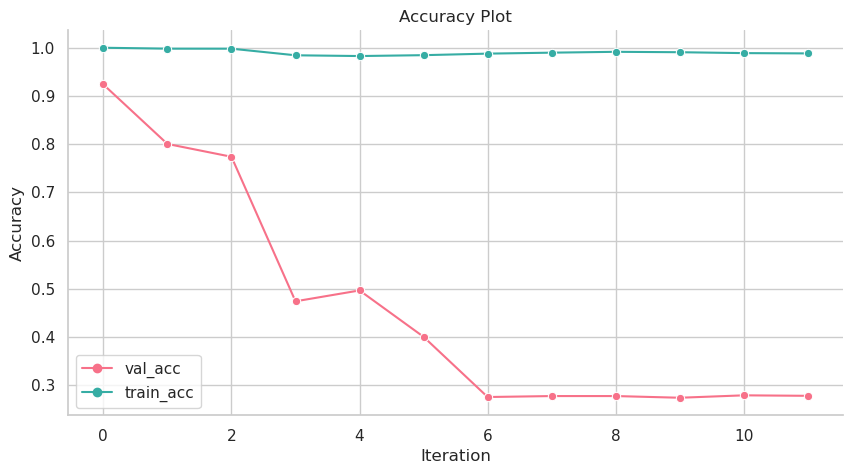

In [8]:
index = 20
# Load Probs from history
history = history_list[index]

# Make a dataframe to plot
val_acc = [max(accs) for accs in history['val_acc']]
train_acc = [max(accs) for accs in history['train_acc']]
df = pd.DataFrame(dict(val_acc=val_acc, train_acc=train_acc))

# Set plot size
plt.figure(figsize=(10,5))
sns.set_style('whitegrid')
# Plot the lines
sns.lineplot(df,dashes=False,markers='o',palette=sns.color_palette("husl", 2))
# Adjust border
sns.despine(top=True,right=True)
# Set Labels, legends and ticks
plt.title('Accuracy Plot')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend(facecolor="w")
# plt.xticks([*range(0,len(history['iteration']),len(history['iteration'])//20)],labels=[*range(1,len(history['iteration'])+1,len(history['iteration'])//20)])

# Plot
plt.show()

##### Save

In [9]:
datasets = history_dict.datasets
strategies = history_dict.strategies[1]
for dataset in datasets:
    for strategy in strategies:
        history_list = history_dict[dataset][strategy]
        for history in tqdm(history_list, desc=dataset.title()+', '+strategy.title()):
        
            # Make save dir
            plots_dir=make_save_dir(base_dir,history)
            
            # Make a dataframe to plot
            val_acc = [max(accs) for accs in history['val_acc']]
            train_acc = [max(accs) for accs in history['train_acc']]
            df = pd.DataFrame(dict(val_acc=val_acc, train_acc=train_acc))

            # Set plot size
            plt.figure(figsize=(10,5))
            sns.set_style('whitegrid')
            # Plot the lines
            sns.lineplot(df,dashes=False,markers='o',palette=sns.color_palette("husl", 2))
            # Adjust border
            sns.despine(top=True,right=True)
            # Set Labels, legends and ticks
            plt.title('Accuracy Plot')
            plt.xlabel("Iteration")
            plt.ylabel("Accuracy")
            plt.legend(facecolor="w")
            # plt.xticks([*range(0,len(history['iteration']),max(len(history['iteration'])//20,1))],\
            #     labels=[*range(1,len(history['iteration'])+1,max(len(history['iteration'])//20,1))])

            # Save
            plt.savefig(plots_dir+'/'+"acc_plot.png",bbox_inches="tight");
            plt.clf();
            plt.close('all');

Yahoo_Answers_10, Top_K: 100%|██████████| 40/40 [00:12<00:00,  3.15it/s]


#### Classwise metrics for each Config

##### Plot

In [10]:
dataset = history_dict.datasets[0]
strategy = history_dict.strategies[0][1]
history_list = history_dict[dataset][strategy]

iter_lens = [len(history['iteration']) for history in history_list]
sorted_ = sorted(list(set(iter_lens)))
indices = [iter_lens.index(val) for val in sorted_]
print('Dataset  :', dataset)
print('Strategy :', strategy)
print('Indices  :', indices)
print('Unique   :', sorted_)
print('Iter Lens:', iter_lens)

Dataset  : dbpedia_14
Strategy : random_top_k
Indices  : [20, 0, 1, 3]
Unique   : [12, 22, 43, 85]
Iter Lens: [22, 43, 43, 85, 22, 43, 43, 85, 22, 43, 43, 85, 22, 43, 43, 85, 22, 43, 43, 85, 12, 22, 22, 43, 12, 22, 22, 43, 12, 22, 22, 43, 12, 22, 22, 43, 12, 22, 22, 43]


In [ ]:
index = 20
metric = 'acc' # acc, f1

# Load Probs from history
history = history_list[index]
cw_acc_dict = {class_:[] for class_ in range(len(history['val_cw_'+metric][0][0]))}
for acc_list, cw_acc_list in zip(history['val_acc'],history['val_cw_'+metric]):
    max_idx = acc_list.index(max(acc_list))
    for class_, acc in enumerate(cw_acc_list[max_idx]):
        cw_acc_dict[class_].append(acc)

df=pd.DataFrame()
for key, val in cw_acc_dict.items():
    df[class_labels[dataset][key]]=val

# Set plot size
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
# Plot the lines
sns.lineplot(df,dashes=False,lw=1.5, markers='o', palette=sns.color_palette("husl", df.shape[1]))
# Adjust border
sns.despine(top=True,right=True)
# Set Labels, legends and ticks
plt.title("Classwise "+metric.title()+' Plot')
plt.xlabel("Iteration")
plt.ylabel(metric.title())
plt.legend(facecolor="w",edgecolor='b')
# plt.xticks([*range(len(history['iteration']))],labels=[*range(1,len(history['iteration'])+1)])

# Plot
plt.show()

##### Save

In [11]:
metrics = ['acc', 'f1'] # acc, f1

datasets = history_dict.datasets
strategies = history_dict.strategies[1]
for dataset in datasets:
    for strategy in strategies:
        history_list = history_dict[dataset][strategy]
        for history in tqdm(history_list, desc=dataset.title()+', '+strategy.title()):
            for metric in metrics:
                # Make save dir
                plots_dir = make_save_dir(base_dir,history)
                
                # Load Probs from history
                cw_acc_dict = {class_:[] for class_ in range(len(history['val_cw_'+metric][0][0]))}
                for acc_list, cw_acc_list in zip(history['val_acc'],history['val_cw_'+metric]):
                    max_idx = acc_list.index(max(acc_list))
                    for class_, acc in enumerate(cw_acc_list[max_idx]):
                        cw_acc_dict[class_].append(acc)

                df=pd.DataFrame()
                for key, val in cw_acc_dict.items():
                    df[class_labels[dataset][key]]=val

                # Set plot size
                plt.figure(figsize=(10,5))
                sns.set_style("whitegrid")
                # Plot the lines
                sns.lineplot(df,dashes=False,lw=1.5, markers='o', palette=sns.color_palette("husl", df.shape[1]))
                # Adjust border
                sns.despine(top=True,right=True)
                # Set Labels, legends and ticks
                plt.title("Classwise "+metric.title()+' Plot')
                plt.xlabel("Iteration")
                plt.ylabel(metric.title())
                plt.legend(facecolor="w")
                # plt.xticks([*range(len(history['iteration']))],labels=[*range(1,len(history['iteration'])+1)])

                # Save
                plt.savefig(plots_dir+'/'+"cw_"+metric+"_plot.png",bbox_inches="tight");
                plt.clf();
                plt.close('all');

Yahoo_Answers_10, Top_K: 100%|██████████| 40/40 [00:27<00:00,  1.46it/s]


### 3.4 Selection plots

#### Plot

In [6]:
dataset = history_dict.datasets[0]
strategy = history_dict.strategies[0][1]
history_list = history_dict[dataset][strategy]

iter_lens = [len(history['iteration']) for history in history_list]
sorted_ = sorted(list(set(iter_lens)))
indices = [iter_lens.index(val) for val in sorted_]
print('Dataset  :', dataset)
print('Strategy :', strategy)
print('Indices  :', indices)
print('Unique   :', sorted_)
print('Iter Lens:', iter_lens)

Dataset  : dbpedia_14
Strategy : random_top_k
Indices  : [20, 0, 1, 3]
Unique   : [12, 22, 43, 85]
Iter Lens: [22, 43, 43, 85, 22, 43, 43, 85, 22, 43, 43, 85, 22, 43, 43, 85, 22, 43, 43, 85, 12, 22, 22, 43, 12, 22, 22, 43, 12, 22, 22, 43, 12, 22, 22, 43, 12, 22, 22, 43]


In [ ]:
index = 0

# Load Probs from history
history = history_list[index]

# Make a dataframe to plot
in_domain = deepcopy(history['selected_in_domain'])
out_domain = deepcopy([a-b for a,b in zip(history['selected_set_size'],history['selected_in_domain'])])
selected = deepcopy(history['selected_set_size'])

for i in range(1,len(in_domain)):
    in_domain[i] = in_domain[i-1]+in_domain[i]
    out_domain[i] = out_domain[i-1]+out_domain[i]
    selected [i]= selected[i-1]+selected[i]

df = pd.DataFrame(dict(in_domain=in_domain, out_domain=out_domain, selected=selected))

# Set plot size
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
# Plot the lines
sns.lineplot(df,dashes=False,markers='o',palette=sns.color_palette("husl", 3))
# Adjust border
sns.despine(top=True,right=True)
# Set Labels, legends and ticks
plt.title('Cumulative Selection Plot')
plt.xlabel("Iteration")
plt.ylabel("Count")
plt.legend(facecolor="w",edgecolor='b')
# plt.xticks([*range(len(history['iteration']))],labels=[*range(1,len(history['iteration'])+1)])

# Plot
plt.show()

#### Save

In [10]:
datasets = history_dict.datasets
strategies = history_dict.strategies[1]
for dataset in datasets:
    for strategy in strategies:
        history_list = history_dict[dataset][strategy]
        for history in tqdm(history_list, desc=dataset.title()+', '+strategy.title()):
        
            # Make save dir
            plots_dir=make_save_dir(base_dir,history)

            # Make a dataframe to plot
            in_domain = deepcopy(history['selected_in_domain'])
            out_domain = deepcopy([a-b for a,b in zip(history['selected_set_size'],history['selected_in_domain'])])
            selected = deepcopy(history['selected_set_size'])

            for i in range(1,len(in_domain)):
                in_domain[i] = in_domain[i-1]+in_domain[i]
                out_domain[i] = out_domain[i-1]+out_domain[i]
                selected [i]= selected[i-1]+selected[i]

            df = pd.DataFrame(dict(in_domain=in_domain, out_domain=out_domain, selected=selected))

            # Set plot size
            plt.figure(figsize=(10,5))
            sns.set_style("whitegrid")
            # Plot the lines
            sns.lineplot(df,dashes=False,markers='o',palette=sns.color_palette("husl", 3))
            # Adjust border
            sns.despine(top=True,right=True)
            # Set Labels, legends and ticks
            plt.title('Cumulative Selection Plot')
            plt.xlabel("Iteration")
            plt.ylabel("Count")
            plt.legend(facecolor="w")
            # plt.xticks([*range(len(history['iteration']))],labels=[*range(1,len(history['iteration'])+1)])

            # Save
            plt.savefig(plots_dir+'/'+"selection_plot.png",bbox_inches="tight");
            plt.clf();
            plt.close('all');

Yahoo_Answers_10, Top_K: 100%|██████████| 40/40 [00:12<00:00,  3.33it/s]


### 3.5 Distribution Counts

In [ ]:
distribution = 'train'
index = 5
for history in history_list[index:index+1]:
    pre_title = 'Threshold: '+str(history['threshold']) if history['strategy']=='threshold' else\
                'Top K: '+str(history['top_k']) , "Labeled Size:"+str(history['labeled_set_size'][0])+\
                    ", Unlabeled Classes: "+str(len(history['unlabeled_classes']))
    print(distribution.title()+' Distribution,',pre_title)
    
    itr = history['iteration']
    unlabeled_dist = [val.values() for val in history[distribution.lower()+'_distribution']]
   
    df = pd.DataFrame(columns=['Iteration']+[str(clss) for clss in history[distribution.lower()+'_distribution'][0].keys()])
    for i, counts in zip(itr,unlabeled_dist):
        df.loc[len(df)] = [i]+ list(counts)

    display(df)

## Debug

In [42]:
fig = px.colors.qualitative.swatches()
fig.update_layout(template='plotly_white')
fig.write_html(base_dir+"/colors.html")

In [44]:
print(px.colors.named_colorscales())

['aggrnyl', 'agsunset', 'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'darkmint', 'electric', 'emrld', 'gnbu', 'greens', 'greys', 'hot', 'inferno', 'jet', 'magenta', 'magma', 'mint', 'orrd', 'oranges', 'oryel', 'peach', 'pinkyl', 'plasma', 'plotly3', 'pubu', 'pubugn', 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu', 'rdpu', 'redor', 'reds', 'sunset', 'sunsetdark', 'teal', 'tealgrn', 'turbo', 'viridis', 'ylgn', 'ylgnbu', 'ylorbr', 'ylorrd', 'algae', 'amp', 'deep', 'dense', 'gray', 'haline', 'ice', 'matter', 'solar', 'speed', 'tempo', 'thermal', 'turbid', 'armyrose', 'brbg', 'earth', 'fall', 'geyser', 'prgn', 'piyg', 'picnic', 'portland', 'puor', 'rdgy', 'rdylbu', 'rdylgn', 'spectral', 'tealrose', 'temps', 'tropic', 'balance', 'curl', 'delta', 'oxy', 'edge', 'hsv', 'icefire', 'phase', 'twilight', 'mrybm', 'mygbm']


In [ ]:
for name in history_files:
    history = torch.load(name)
    labeled = history['labeled_set_size'][1:]+[history['unlabeled_set_size'][0]]
    unlabeled = history['unlabeled_set_size'][1:]+[0]
    history['labeled_set_size']=labeled
    history['unlabeled_set_size']=unlabeled
    torch.save(history,name)

In [ ]:
for root, dirs, files in os.walk("./history"):
   for name in files:
      print(os.path.join(root, name))
   for name in dirs:
      print(os.path.join(root, name))